In [150]:
# Learning Practice 4 for the University of Tulsa's QM-7063 Data Mining Course
# Cluster Analysis
# Professor: Dr. Abdulrashid, Spring 2023
# Noah L. Schrick - 1492657

%matplotlib inline

from pathlib import Path

import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import pairwise
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
import matplotlib.pylab as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates



pd.options.mode.chained_assignment = None  # default='warn'


# Problem 15.1
The dataset on American College and University Rankings (available from www.dataminingbook.com) contains information on 1302 American
colleges and universities offering an undergraduate program. For each university, there are 17 measurements, including continuous measurements (such as tuition and graduation rate) and categorical measurements (such as location by state and whether it is a private or public school).

Note that many records are missing some measurements. Our first goal is to estimate these missing values from “similar” records. This will be done by clustering the complete records and then finding the closest cluster for each of the partial records. The missing values will be imputed from the information in that cluster. 

a. 
    Remove all records with missing measurements from the dataset.
b. 
    For all the continuous measurements, run hierarchical clustering using complete linkage and Euclidean distance. Make sure to normalize the measurements. From the dendrogram: How many clusters seem reasonable for describing these data?
c. 
    Compare the summary statistics for each cluster and describe each cluster in this context (e.g., “Universities with high tuition, low acceptance rate...”). (Hint: To obtain cluster statistics for hierarchical clustering, use the pandas method groupby(clusterlabel) together with methods such as mean or median.)
d. 
    Use the categorical measurements that were not used in the analysis (State and Private/Public) to characterize the different clusters. Is there any relationship between the clusters and the categorical information?
e. 
    What other external information can explain the contents of some or all of these clusters?
f. 
    Consider Tufts University, which is missing some information. Compute the Euclidean distance of this record from each of the clusters that you found above (using only the measurements that you have). Which cluster is it closest to? Impute the missing values for Tufts by taking the average of the cluster on those measurements.

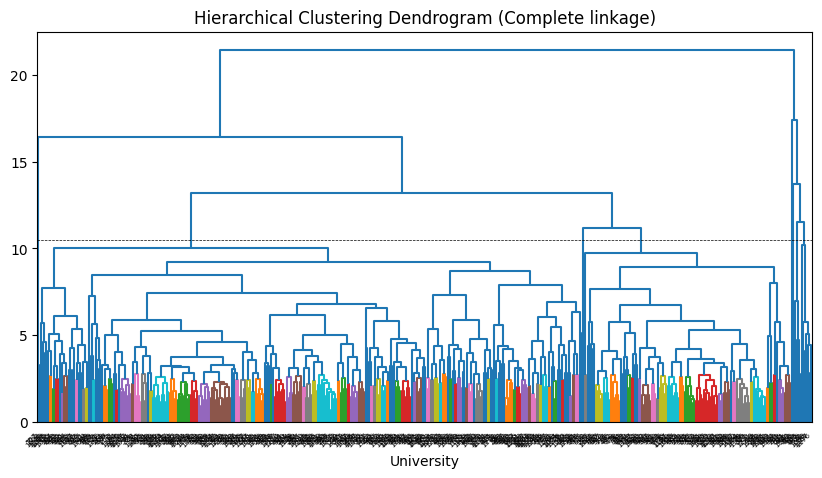

        # appli. rec'd  # appl. accepted  # new stud. enrolled  \
mean     -1.885729e-17      1.131437e-17          3.630029e-17   
median   -3.685865e-01     -3.338810e-01         -3.688211e-01   

        % new stud. from top 10%  % new stud. from top 25%  # FT undergrad  \
mean                9.051500e-17             -3.771458e-17   -2.074302e-17   
median             -2.712639e-01             -8.127227e-02   -3.957697e-01   

        # PT undergrad  in-state tuition  out-of-state tuition          room  \
mean      3.771458e-17      7.354344e-17          2.130874e-16 -8.297208e-17   
median   -3.224580e-01      8.181657e-02         -1.102035e-01 -1.838341e-01   

               board     add. fees  estim. book costs  estim. personal $  \
mean   -2.753165e-16  3.771458e-18       1.131437e-17       9.805791e-17   
median -7.045916e-02 -2.782627e-01      -2.989446e-01      -1.641725e-01   

        % fac. w/PHD  stud./fac. ratio  Graduation rate  
mean    2.413733e-16      1.508583e-17

In [168]:
raw_university_df = pd.read_csv('Universities.csv')

# a: Remove all records with missing measurements
university_df = raw_university_df.dropna() # 1302 rows -> 471 rows

# Normalize
university_df_num = university_df.select_dtypes(include='number') # get numeric cols only
university_df_num = university_df_num.drop('Public (1)/ Private (2)', axis=1) # drop the discrete column
university_df_num_norm = (university_df_num - university_df_num.mean(numeric_only=True))/university_df_num.std(numeric_only=True) # normalize
university_df.update(university_df_num_norm) # merge

# b: hierarchical clustering using complete linkage and Euclidean distance
university_dist = pairwise.pairwise_distances(university_df_num_norm, 
                                     metric='euclidean')
pd.DataFrame(university_dist, columns=university_df.index, index=university_df.index).head(5)

uni_hclust = fcluster(linkage(university_df_num_norm, 'complete'), 6, criterion='maxclust')

Z = linkage(university_df_num_norm, method='complete')

fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title('Hierarchical Clustering Dendrogram (Complete linkage)')
plt.xlabel('University')
dendrogram(Z, labels=university_df_num_norm.index, color_threshold=2.75)
plt.axhline(y=10.5, color='black', linewidth=0.5, linestyle='dashed')
plt.xticks(rotation=45, ha='right')
plt.show()
# reasonable number of clusters for describing the data:
# At distance of 10.5 (horizontal line in the dendrogram image) data can be reduced to 9 clusters

# c:  Compare the summary statistics for each cluster
cutree = cluster.hierarchy.cut_tree(Z, n_clusters=[5, 10])
clust_stats = university_df_num_norm.agg(['mean', 'median'])
print(clust_stats)

# d: Use the categorical measurements to categorize
state_table = tabulate(university_df[['State']], cutree)
pub_priv_table = tabulate(university_df[['Public (1)/ Private (2)']], cutree)
print(state_table)

# e: Other external information
# There are multiple external factors that can explain these clusters. Notably, that these clusters are
# built with only partial information. Since the pre-processing step removed all entries with NaNs, the
# total number of entries was reduced from 1302 to 471, which is a very large amount of missing data.
# Second, school funding priorities can affect some of the school data. Depending on how funding is allocated
# to sports, liberal arts, research, campus maintenance, events, etc, the underlying data may change.
# The socioeconomic factors involved with private vs public universities may also change the data.

# f: Compute the Euclidean distance of this record from each of the clusters that you found above (using only the measurements that you have)
tufts_df = raw_university_df.loc[raw_university_df['College Name'] == 'Tufts University']
tufts_df = tufts_df.drop(['# PT undergrad'], axis=1)
tufts_df_num = tufts_df.select_dtypes(include='number') # get numeric cols only

tufts_dist = pairwise.pairwise_distances(tufts_df_num, Y=university_df_num_norm, metric='euclidean')

# Closest cluster:
print(raw_university_df.iloc[np.where(tufts_dist == tufts_dist.min())[1][0]]['College Name'])

# impute missing (from raw data - non-normalized)
tufts_df['# PT undergrad'] = clust_stats['# PT undergrad']['mean']
print(tufts_df['# PT undergrad'])

# Problem 15.4
The file EastWestAirlinesCluster.csv contains information on 3999 passengers who belong to an airline’s frequent flier program. For each passenger, the data include information on their mileage history and on different ways they accrued or spent miles in the last year. The goal is to try to identify clusters of passengers that have similar characteristics for the purpose of targeting different segments for different types of mileage offers.

a. 
    Apply hierarchical clustering with Euclidean distance and Ward’s method. Make sure to normalize the data first. How many clusters appear?
b. 
    What would happen if the data were not normalized?
c. 
    Compare the cluster centroid to characterize the different clusters, and try to give each cluster a label.

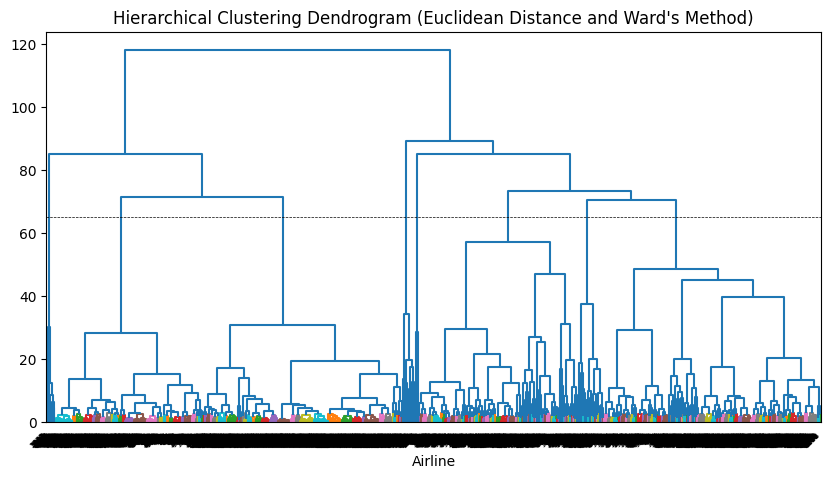

/home/noah/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


        ID#   Balance  Qual_miles  cc1_miles  cc2_miles  cc3_miles  \
0  0.957102 -0.392262   -0.136428  -0.717780  -0.098242  -0.062767   
1 -0.842588 -0.161087   -0.107379  -0.515236  -0.098242  -0.058526   
2 -0.167650  1.103818    0.467739   0.071777  -0.098242  -0.062767   
3 -0.301522  0.639719   -0.084433   1.022084  -0.098242  15.646299   
4  0.538585 -0.001928   -0.127412   0.830568  -0.098242  -0.048809   
5  0.089763  0.417981    7.087067  -0.043229  -0.098242  -0.062767   
6  0.219325 -0.046890   -0.156236  -0.668227   9.038254  -0.062767   
7 -0.929265  0.876328   -0.078554   1.535043  -0.098242  -0.062767   

   Bonus_miles  Bonus_trans  Flight_miles_12mo  Flight_trans_12  \
0    -0.580379    -0.639577          -0.194036        -0.217088   
1    -0.472057    -0.394837          -0.148568        -0.159181   
2     0.658657     1.810074           4.088700         4.348639   
3     3.179691     1.714614           0.033293         0.059695   
4     0.394766     0.636493       

In [164]:
raw_airlines_df = pd.read_csv('EastWestAirlinesCluster.csv')

# Normalize
airlines_df_norm = raw_airlines_df.apply(preprocessing.scale, axis=0)

# a: hclust with euclidean and ward's
Z = linkage(airlines_df_norm, method='ward', metric='euclidean')
fig = plt.figure(figsize=(10, 6))
fig.subplots_adjust(bottom=0.23)
plt.title("Hierarchical Clustering Dendrogram (Euclidean Distance and Ward's Method)")
plt.xlabel('Airline')
dendrogram(Z, labels=airlines_df_norm.index, color_threshold=2.75)
plt.axhline(y=65, color='black', linewidth=0.5, linestyle='dashed')
plt.xticks(rotation=45, ha='right')
plt.show()

# b: Text answer

# c: 
kmeans = KMeans(n_clusters=8, random_state=0).fit(airlines_df_norm)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=airlines_df_norm.columns)
#pd.set_option('precision', 3)
print(centroids)


In [167]:
# Cluster membership
memb = pd.Series(kmeans.labels_, index=airlines_df_norm.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(str(item.index[0])))

0 :  1, 1, 2, 9
1 :  0
2 :  6, 5
3 :  1, 0, 6
4 :  1, 1, 4, 1
5 :  7, 0
6 :  8
7 :  4
